<a href="https://colab.research.google.com/github/gladysbabs/Prediction-of-Product-Sales/blob/main/Prediction_of_Product_Sales_(FINAL)_Gladys_Babirye.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np

In [3]:
df=pd.read_csv("/content/drive/MyDrive/CodingDojo/02-IntroML/Week05/Data/sales_predictions_2023.csv")
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [ ]:
#checking data types
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

- The data types are as expected as per the data dictionary.

In [ ]:
#Checking for duplicates
df.duplicated().sum()

0

- No duplicates

In [ ]:
#Checking for inconsistencies
cat_cols=df.select_dtypes(object)
#
for cols in cat_cols:
  print(f"The value count for {cols}")
  print(df[cols].value_counts())
  print('\n')

The value count for Item_Identifier
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64


The value count for Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64


The value count for Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64


The value count for Outlet_Identifier
OUT027    935
OUT013    932
OUT049    930
OU

In [4]:
#Addressing the inconsistency in 'Item_Fat_Content': LF:Low_Fat,reg:Regular,low fat:Low Fat

df['Item_Fat_Content']=df['Item_Fat_Content'].replace({'LF':'Low Fat','reg':'Regular','low fat':'Low Fat'})

In [ ]:
#checking for missing values:
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

- Missing values need to be addressed.
 - Using EDA functions to zero down on how to analyze the missing values.

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

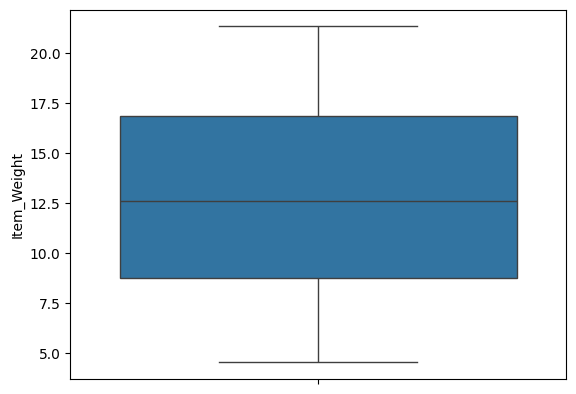

In [ ]:
#Using a boxplot to find out which imputer to use for the numeric_column: 'Item_Weight'
ax=sns.boxplot(df,y='Item_Weight')

- There is no skewness or any outliers in the boxplot. Therefore whether I use the median or mean as an imputer, the results will still be the same.
   - Therefore I'll go ahead and use the median imputer for the numeric column 'Item_Weight'

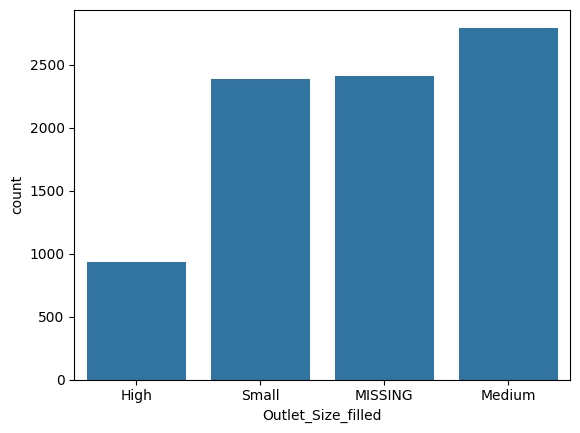

In [ ]:
#Using a countplot to find out which imputer to use for the categorical column: 'Outlet_Size'
order_outlet=['High','Small','MISSING','Medium']

df['Outlet_Size_filled'] = df['Outlet_Size'].fillna('MISSING')
ax=sns.countplot(df,x='Outlet_Size_filled',order=order_outlet)

In [ ]:
df['Outlet_Size'].value_counts(dropna=False)

Medium    2793
NaN       2410
Small     2388
High       932
Name: Outlet_Size, dtype: int64

- Indeed the null values are quite significant and we shall address them by filling them with the 'most_frequent' value.

## Declaring (X) features and the (y) target.

In [ ]:
y=df['Item_Outlet_Sales']
features=df.drop(columns=['Item_Outlet_Sales'])
#Dropping the column 'Item_Identifier' as well because it has a very high cardinality.
X=features.drop(columns=['Item_Identifier'])

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder,StandardScaler


In [ ]:
#Train_test_Split
X_train,X_test,y_train,y_test=train_test_split(X,y)

## Pipelines

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config
set_config(transform_output='pandas')

In [ ]:
num_cols=X_train.select_dtypes('number').columns
ord_cols=['Item_Fat_Content','Outlet_Size','Outlet_Location_Type']
cat_cols=X_train.select_dtypes('object').drop(columns=ord_cols).columns

In [ ]:
#Pipeline for numerical data using the imputer strategy as median
imputer_median=SimpleImputer(strategy='median')
scaler=StandardScaler()
num_pipeline=make_pipeline(imputer_median,scaler)

In [ ]:
#Pipeline for ordinal data
imputer_mos=SimpleImputer(strategy='most_frequent')
#The different categories' orders:
fat_ord=['Regular','Low Fat']
out_size_ord=['Small','Medium','High']
out_loc_ord=['Tier 1','Tier 2','Tier 3']
ordinal_category_orders=[fat_ord,out_size_ord,out_loc_ord]
#Ordinal encoder
ord_encoder = OrdinalEncoder(categories=ordinal_category_orders)
#Scaling ordinal features
ord_scale=StandardScaler()
#The pipeline
ord_pipeline=make_pipeline(imputer_mos,ord_encoder,ord_scale)


In [ ]:
#pipeline for categorical data:
impute_na=SimpleImputer(strategy='constant',fill_value='MISSING')
#OneHotEncoding
ohe_cat=OneHotEncoder(sparse_output=False,handle_unknown='ignore')
#cat_pipeline
cat_pipeline=make_pipeline(impute_na,ohe_cat)

##The preprocessor

In [ ]:
cat_tuple=('categorical',cat_pipeline,cat_cols)

num_tuple=('numeric',num_pipeline,num_cols)

ord_tuple=('ordinal',ord_pipeline,ord_cols)

col_transformer=ColumnTransformer([cat_tuple,num_tuple,ord_tuple],verbose_feature_names_out=False)


In [ ]:
#Fitting the column transformer on the X_train data:
col_transformer.fit(X_train)

ColumnTransformer(transformers=[('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['Item_Type', 'Outlet_Identifier', 'Outlet_Type'], dtype='object')),
                                ('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strat...
      dtype='object')),
                                ('ordinal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Regular',
                                                                              'Low '
                                                                              'Fat'],
                                                                             ['Small',
                                                                              'Medium',
                                                                              'High'],
                                                                             ['Tier '
                                                                              '1',
                                                                              'Tier '
                                                                              '2',
                                                                              'Tier '
                                                                              '3']])),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Item_Fat_Content', 'Outlet_Size',
                                  'Outlet_Location_Type'])],
                  verbose_feature_names_out=False)

In [ ]:
#Transforming the X_train data:
X_train_processed=col_transformer.transform(X_train)
#Transforming the X_test data:
X_test_processed=col_transformer.transform(X_test)

In [ ]:
#confirming that all columns are numeric dtypes:
X_train_processed.dtypes

Item_Type_Baking Goods             float64
Item_Type_Breads                   float64
Item_Type_Breakfast                float64
Item_Type_Canned                   float64
Item_Type_Dairy                    float64
Item_Type_Frozen Foods             float64
Item_Type_Fruits and Vegetables    float64
Item_Type_Hard Drinks              float64
Item_Type_Health and Hygiene       float64
Item_Type_Household                float64
Item_Type_Meat                     float64
Item_Type_Others                   float64
Item_Type_Seafood                  float64
Item_Type_Snack Foods              float64
Item_Type_Soft Drinks              float64
Item_Type_Starchy Foods            float64
Outlet_Identifier_OUT010           float64
Outlet_Identifier_OUT013           float64
Outlet_Identifier_OUT017           float64
Outlet_Identifier_OUT018           float64
Outlet_Identifier_OUT019           float64
Outlet_Identifier_OUT027           float64
Outlet_Identifier_OUT035           float64
Outlet_Iden

In [ ]:
#Confirming that the transformed numeric features have been scaled:
X_train_processed[num_cols].describe().round(2)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
count,6392.00,6392.00,6392.00,6392.00
mean,0.00,0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00
min,-1.95,-1.28,-1.74,-1.52
25%,-0.83,-0.76,-0.76,-1.29
50%,-0.05,-0.24,0.02,0.14
75%,0.78,0.56,0.71,0.74
max,2.02,5.08,2.02,1.33


- As can be seen, the transformed numeric features have been scaled since the mean is approximately 0 and the standard deviation is approximately 1.

#CRISP-DM Phase 4 - Modeling

## Linear Regression Model

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
#Instantiating the Linear regression Model:
lin_reg=LinearRegression()

In [ ]:
#Making the pipeline:
lin_reg_pipe=make_pipeline(col_transformer,lin_reg)

In [ ]:
#fitting the model
lin_reg_pipe.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='MISSING',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Item_Type', 'Outlet_Identifier', 'Outlet_Type'], dtype='object')),
                                                 ('numeric',
                                                  Pipeline(steps=...
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Regular',
                                                                                               'Low '
                                                                                               'Fat'],
                                                                                              ['Small',
                                                                                               'Medium',
                                                                                               'High'],
                                                                                              ['Tier '
                                                                                               '1',
                                                                                               'Tier '
                                                                                               '2',
                                                                                               'Tier '
                                                                                               '3']])),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Item_Fat_Content',
                                                   'Outlet_Size',
                                                   'Outlet_Location_Type'])],
                                   verbose_feature_names_out=False)),
                ('linearregression', LinearRegression())])

In [ ]:
#Getting predictions to evaluate the model:
y_train_predic=lin_reg_pipe.predict(X_train)
y_test_predic=lin_reg_pipe.predict(X_test)

In [ ]:
#Building a function to evaluate my model:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluation_metric(y_true, y_pred, split='Dataset'):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)

    header = '-' * 60
    print(header, split, header, sep='\n')
    print(f'- MAE: {mae:,.2f}')
    print(f'- MSE: {mse:,.2f}')
    print(f'- RMSE: {rmse:,.2f}')
    print(f'- R2-Score: {r2:,.2f}')
    print()

In [ ]:
#evaluating my linear regression model:
evaluation_metric(y_true=y_train, y_pred=y_train_predic, split='Training')
evaluation_metric(y_true=y_test, y_pred=y_test_predic, split='Test')

------------------------------------------------------------
Training
------------------------------------------------------------
- MAE: 836.02
- MSE: 1,281,177.38
- RMSE: 1,131.89
- R2-Score: 0.56

------------------------------------------------------------
Test
------------------------------------------------------------
- MAE: 831.44
- MSE: 1,243,333.79
- RMSE: 1,115.05
- R2-Score: 0.58



- To what extent is this model overfit/underfit?
  - The R2-Score of the test set is slightly higher than that of the training set meaning that the model is performing slightly better on unseen data than on training data. The model is not significantly overfitting or underfitting since the difference in R2-Score between the training and test sets is small.But this could easily suggest that the model is slightly overfitting.

## The Random Forest Model

In [51]:
from sklearn.ensemble import RandomForestRegressor

In [52]:
#Instantiating the Random Forest regressor:
rf=RandomForestRegressor()

In [53]:
#Modeling the pipeline to the regressor:
rf_pipeline=make_pipeline(col_transformer,rf)

In [54]:
#Fitting the model to the training data:
rf_pipeline.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='MISSING',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Item_Type', 'Outlet_Identifier', 'Outlet_Type'], dtype='object')),
                                                 ('numeric',
                                                  Pipeline(steps=...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Regular',
                                                                                               'Low '
                                                                                               'Fat'],
                                                                                              ['Small',
                                                                                               'Medium',
                                                                                               'High'],
                                                                                              ['Tier '
                                                                                               '1',
                                                                                               'Tier '
                                                                                               '2',
                                                                                               'Tier '
                                                                                               '3']])),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Item_Fat_Content',
                                                   'Outlet_Size',
                                                   'Outlet_Location_Type'])],
                                   verbose_feature_names_out=False)),
                ('randomforestregressor', RandomForestRegressor())])

In [56]:
#Getting predictions for the training and test data
y_train_predict=rf_pipeline.predict(X_train)
y_test_predict=rf_pipeline.predict(X_test)

In [57]:
#Using my custom evaluation function to evaluate my Random Forest model:
evaluation_metric(y_true=y_train, y_pred=y_train_predict, split='Training')
evaluation_metric(y_true=y_test, y_pred=y_test_predict, split='Test')

------------------------------------------------------------
Training
------------------------------------------------------------
- MAE: 294.39
- MSE: 182,324.54
- RMSE: 426.99
- R2-Score: 0.94

------------------------------------------------------------
Test
------------------------------------------------------------
- MAE: 796.14
- MSE: 1,270,475.71
- RMSE: 1,127.15
- R2-Score: 0.57



- To what extent is this model overfit/underfit?
 - The r2_score of the training set is much higher than that of the test set meaning that the model is performing very poorly on unseen data.
 The model is indeed overfitting since it has learned the training data too well.

- Which model has the best test scores?
 - For the test data, the Random Forest model has lower MAE compared to the linear regression model, indicating that it performs better in terms of prediction accuracy.
 However, the linear regression model has a slightly higher R2-score (58%) than the R2-score of the Random Forest Model (57%). This difference is significantly small.

  - In summary, when I consider the MAE and r_2 score values, the Random Forest model appears to be a better choice.

### Tuning using GridSearchCV

In [58]:
from sklearn.model_selection import GridSearchCV

In [64]:
#selecting which hyperparameters we shall tune:
rf_pipeline.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('categorical',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(fill_value='MISSING',
                                                                   strategy='constant')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse_output=False))]),
                                    Index(['Item_Type', 'Outlet_Identifier', 'Outlet_Type'], dtype='object')),
                                   ('numeric',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strat...
         dtype='object')),
                                   ('ordinal',
                  

In [66]:
param_grid={'randomforestregressor__n_estimators':[10,50,100,200,300],
            'randomforestregressor__max_depth': [None,10,20,50],
            'randomforestregressor__min_samples_split': [2,5,8,10],
           'randomforestregressor__min_samples_leaf': [1,2,4]}

In [68]:
#Instantiating the Gridsearch:
grid_search=GridSearchCV(rf_pipeline,param_grid,n_jobs = -1, verbose = 1)

In [70]:
#fitting the training data
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('categorical',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(fill_value='MISSING',
                                                                                                        strategy='constant')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         Index(['Item_Type', 'Outlet_Identifier', 'Outlet_Type'], dtype='object')),
                                                                        ('n...
                                                                          'Outlet_Location_Type'])],
                                                          verbose_feature_names_out=False)),
                                       ('randomforestregressor',
                                        RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': [None, 10, 20, 50],
                         'randomforestregressor__min_samples_leaf': [1, 2, 4],
                         'randomforestregressor__min_samples_split': [2, 5, 8,
                                                                      10],
                         'randomforestregressor__n_estimators': [10, 50, 100,
                                                                 200, 300]},
             verbose=1)

In [71]:
def reg_evaluation(reg, X_train, y_train, X_test, y_test, verbose=True, output_frame=False):
    # Predicting the training set:
    y_train_predict = reg.predict(X_train)
    # Evaluation metrics for training set:
    results_train = evaluation_metric(y_train, y_train_predict, split='Training set')
    # Predicting the test set:
    y_test_predict = reg.predict(X_test)
    # Evaluation metrics for test set:
    results_test = evaluation_metric(y_test, y_test_predict, split='Test set')


    if output_frame:
        results_df = pd.DataFrame({'Training set': results_train, 'Test set': results_test})
        results_df.index.name = None
        results_df.index = ['MAE', 'MSE', 'RMSE', 'R2-Score']
        return results_df.round(3)


In [72]:
best_model=grid_search.best_estimator_

In [74]:
#Evaluate my model using my built function:
reg_evaluation(reg=best_model, X_train= X_train, y_train=y_train, X_test=X_test, y_test=y_test)

------------------------------------------------------------
Training set
------------------------------------------------------------
- MAE: 654.71
- MSE: 884,796.80
- RMSE: 940.64
- R2-Score: 0.69

------------------------------------------------------------
Test set
------------------------------------------------------------
- MAE: 762.32
- MSE: 1,168,953.33
- RMSE: 1,081.18
- R2-Score: 0.60



- Compare your tuned model to your default Random Forest model.Did the performance improve?
 - The tuned model's MAE is slightly lower on the test set (762.32) compared to the default model (796.14), indicating improved accuracy.
 - The tuned model's MSE is also lower on the test set (1,168,953.33) compared to the default model (1,270,475.71), indicating better performance in terms of error.
 - The tuned model's RMSE is lower on the test set (1,081.18) compared to the default model (1,127.15), further confirming improved accuracy.
 - The tuned model's R2 score is higher (0.60) compared to the default model (0.57), indicating that the tuned model explains more variance in the target variable.

- With an overview of all the metrics,the performance of the tuned Random Forest model has improved compared to the default Random Forest model,showing the effectiveness of tuning a model.

# CRISP-DM Phase 5 - Evaluation

- Overall, which model do you recommend?
 - The tuned random forest model has its MAE slightly lower on the test set (762.32) compared to the linear model (831.44), indicating improved accuracy.
 - The tuned random forest model has its MSE also lower on the test set (1,168,953.33) compared to the linear model (1,243,333.79), indicating better performance in terms of error.
 - The tuned random forest model has its RMSE lower on the test set (1,081.18) compared to the linear model (1,115.05), further confirming improved accuracy.
 - The tuned random forest model has its R2 score higher (0.60) compared to the default model (0.58), indicating that the tuned model explains more variance in the target variable.

- With this overview,I would recommend the tuned Random Forest model.

- Interpret the tuned Random Forest model's performance based on R-squared.
  - The R-squared (R2) score is a measure of how well the model explains the variance in the target variable. A higher R2 score indicates that the model can better predict the variation in the target variable. In the case of the tuned Random Forest model, it achieved an R2 score of 0.60, which is higher compared to both the default Random Forest and linear regression models. This means that the tuned model explains more of the variance in the target variable than the other models, indicating a better predictive performance.

- I would also select the MSE to express the performance of my tuned Random Forest model when expressing the model performance to a stakeholder. The low MSE on the test set (1,168,953.33) indicates a better performance in error compared to the MSEs of the default Random Forest Model (1,168,953.33) and the Linear Regression model(1,270,475.71). This shows that the tuned Random Forest Model will perform well on the unseen data.

- When comparing the training vs. test scores of the tuned Random Forest Model to explain if the model is overfit/underfit?
 - The MAE is slightly lower on the training set (654.71) compared to the test set (762.32). This shows that the model's predictions are closer to the actual values on the training data than on the unseen test data.

 - The MSE is also lower on the training set (884,796.80) compared to the test set (1,168,953.33). This indicates that the model's predictions deviate less from the actual values on the training data than on the test data.

 - The RMSE is lower on the training set (940.64) compared to the test set (1,081.18). A lower RMSE on the training set suggests that the model has small errors around the mean of the training data compared to the test data.

 - The R2 score on the training set is slightly higher (0.69) compared to test set (0.60). This indicates that a larger proportion of the variance in the target variable is explained by the model on the training data compared to the test data.

 - In conclusion, this model is overfit seeing that it fits better on the training data than the test data.

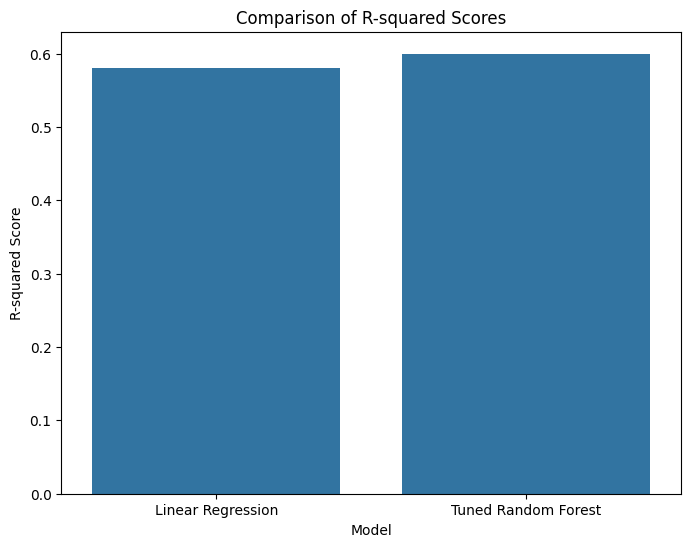

In [9]:
#Plotting a barplot to show the R-squared scores between the linear regression and default random forest models
# Define the R-squared scores
r2_lin = 0.58
r2_tun_rf = 0.60

# Create a DataFrame to use in barplot
data = {'Model': ['Linear Regression', 'Tuned Random Forest'],
        'R-squared Score': [r2_lin, r2_tun_rf]}
df2 = pd.DataFrame(data)

# Plotting the barplot
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=df2, x='Model', y='R-squared Score')
ax.set_title('Comparison of R-squared Scores')
ax.set_ylabel('R-squared Score')
plt.show()


- This barplot visualization shows that the random forest model explains a slightly higher proportion of the variance in the target variable compared to the linear regression model.

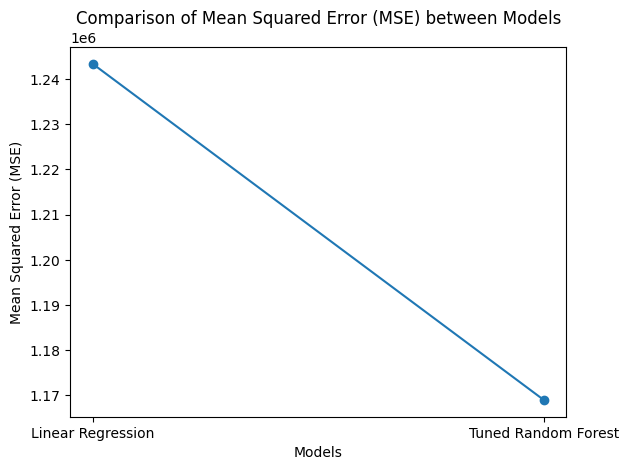

In [12]:
#comparing the mean squared error (MSE) values between the 2 models using a lineplot:

# The data
models = ['Linear Regression', 'Tuned Random Forest']
mse_values = [1243333.79, 1168953.33]

# Creating the line plot
plt.plot(models, mse_values, marker='o', linestyle='-')

plt.xlabel('Models')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparison of Mean Squared Error (MSE) between Models')

plt.show()

- This visualization shows the difference in the predictive performance between the two models.
- The MSE of the tuned Random Forest model is lower than that of the linear regression model, showing that the tuned Random Forest model has a lower predictive error and potentially a better predictive performance.